from google.colab import drive
drive.mount('/content/drive')

import os
%cd /content/drive/MyDrive/Universidad/Aprendizaje Automático II/Práctica/Trabajos/FINAL/IMAGENES

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Definir transformaciones para los datos de entrenamiento y validación
transformaciones = transforms.Compose([
    transforms.Resize((100, 100)),  # Redimensionar las imágenes
    transforms.ToTensor()  # Convertir las imágenes a tensores
])

# Cargar los datos de entrenamiento y validación
dataset_entrenamiento = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/train', transform=transformaciones)
dataset_validacion = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/validation', transform=transformaciones)
dataset_test = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/test', transform=transformaciones)

In [2]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Nueva capa convolucional

        # Batch Normalization para cada capa convolucional
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=128)  # Normalización para la nueva capa

        # MaxPooling y Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout_conv = nn.Dropout(p=0.25)  # Dropout para capas convolucionales
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout para capas densas

        # Capas completamente conectadas
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  # Ajuste del tamaño según salida de la última capa convolucional
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)  # Salida para 7 clases

        # Batch Normalization para capas densas
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc_bn2 = nn.BatchNorm1d(128)

    def forward(self, x):
        # Pasos convolucionales con activación, normalización y pooling
        x = self.pool(F.sigmoid(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.sigmoid(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.sigmoid(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.sigmoid(self.bn4(self.conv4(x))))  # Nueva capa convolucional
        x = self.dropout_conv(x)

        # Aplanar para pasar a capas densas
        x = x.view(-1, 128 * 6 * 6)

        # Pasos densos con activación, normalización y dropout
        x = F.sigmoid(self.fc_bn1(self.fc1(x)))
        x = self.dropout_fc(x)

        x = F.sigmoid(self.fc_bn2(self.fc2(x)))
        x = self.dropout_fc(x)

        x = self.fc3(x)  # Sin activación final porque CrossEntropyLoss la incluye
        return x


In [4]:
def graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion):
    # Crear una figura con dos subgráficos en una fila
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Graficar la función de pérdida en el primer subgráfico
    ax[0].plot(valores_perdida, label='Pérdida')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Pérdida')
    ax[0].set_title(f'Función de Pérdida\n LR: {lr} Batch Size: {batch_size}')
    ax[0].legend()

    # Graficar las exactitudes en el segundo subgráfico
    ax[1].plot(exactitud_entrenamiento, label='Exactitud de Entrenamiento')
    ax[1].plot(exactitud_validacion, label='Exactitud de Validación')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Exactitud')
    ax[1].set_title(f'Exactitud de Entrenamiento y Validación\n LR: {lr} Batch Size: {batch_size}')
    ax[1].legend()

    # Ajustar espaciado entre los gráficos
    plt.tight_layout()

    # Mostrar los gráficos
    plt.show()

In [5]:
def calcular_exactitud_test(modelo, dataloader_test, device):
    correctas = 0
    total = 0
    with torch.no_grad():
        modelo.eval()

        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = modelo(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correctas += (predicted == labels).sum().item()
        #print(f'Exactitud de el modelo con las {total} imágenes de test: {100*correctas/total}%')
    return 100*correctas/total

In [6]:
def matriz_de_confusion(modelo, dataloader_test, device):

    modelo.eval()

    # Inicializar listas para etiquetas reales y predicciones
    predicciones_totales = []
    etiquetas_reales_totales = []

    # Verificar que el dataloader_test tiene datos
    if len(dataloader_test.dataset) == 0:
        print("El conjunto de test está vacío. Verifica los datos.")
    else:
        # Bucle para obtener predicciones
        with torch.no_grad():
            for imagenes, etiquetas in dataloader_test:
                imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
                salidas = modelo(imagenes)
                _, predicciones = torch.max(salidas, 1)
                predicciones_totales.extend(predicciones.cpu().numpy())
                etiquetas_reales_totales.extend(etiquetas.cpu().numpy())

    # Comprobar si se obtuvieron predicciones
    if len(etiquetas_reales_totales) > 0 and len(predicciones_totales) > 0:
        # Imprimir el reporte de clasificación
        print("Reporte de clasificación:")
        print(classification_report(etiquetas_reales_totales, predicciones_totales, digits=4))

        # Crear la matriz de confusión
        etiquetas_unicas = sorted(set(etiquetas_reales_totales))  # Identificar las clases presentes
        matriz_confusion_test = confusion_matrix(etiquetas_reales_totales, predicciones_totales, labels=etiquetas_unicas)

        # Visualizar la matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_unicas, yticklabels=etiquetas_unicas)
        plt.xlabel('Predicciones')
        plt.ylabel('Etiquetas Reales')
        plt.title('Matriz de Confusión del Conjunto de Test')
        plt.show()

        # Mostrar las clases presentes
        clases_presentes = set(etiquetas_reales_totales)
        print(f"Clases presentes en el conjunto de test: {clases_presentes}")
    else:
        print("No se encontraron datos válidos para generar predicciones o etiquetas.")


Entrenando con lr=0.005, batch_size=32, epochs=15
    Época 1, pérdida: 1.7805, exactitud entrenamiento: 34.84%, exactitud validación: 34.50%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.5162, exactitud entrenamiento: 40.36%, exactitud validación: 40.37%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.3959, exactitud entrenamiento: 45.10%, exactitud validación: 43.58%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.2968, exactitud entrenamiento: 65.31%, exactitud validación: 62.20%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.2543, exactitud entrenamiento: 65.62%, exactitud validación: 60.46%
Learning rate actual: 0.005000
    Época 6, pérdida: 1.1967, exactitud entrenamiento: 51.11%, exactitud validación: 48.62%
Learning rate actual: 0.005000
    Época 7, pérdida: 1.1339, exactitud entrenamiento: 66.64%, exactitud validación: 62.39%
Learning rate actual: 0.005000
    Época 8, pérdida: 1.1196, exactitud entrenamiento: 47.20%, exactitud validación: 46.

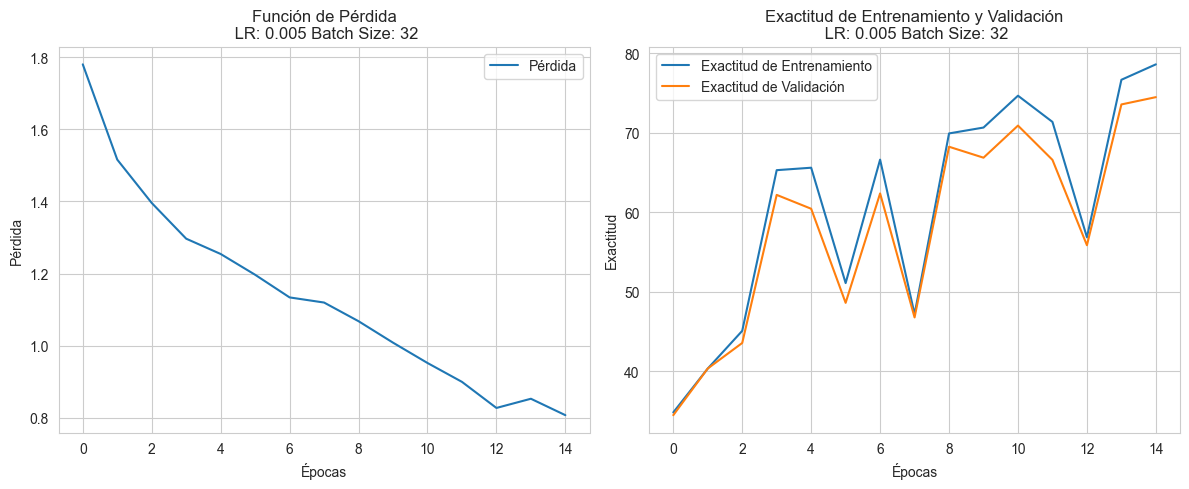


Entrenando con lr=0.005, batch_size=32, epochs=30
    Época 1, pérdida: 1.7754, exactitud entrenamiento: 18.95%, exactitud validación: 18.99%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.5421, exactitud entrenamiento: 49.48%, exactitud validación: 47.16%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.4385, exactitud entrenamiento: 39.53%, exactitud validación: 40.00%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.3304, exactitud entrenamiento: 52.34%, exactitud validación: 53.03%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.3046, exactitud entrenamiento: 49.72%, exactitud validación: 49.17%
Learning rate actual: 0.005000
    Época 6, pérdida: 1.2332, exactitud entrenamiento: 64.23%, exactitud validación: 60.64%
Learning rate actual: 0.005000
    Época 7, pérdida: 1.1672, exactitud entrenamiento: 69.81%, exactitud validación: 66.15%
Learning rate actual: 0.005000
    Época 8, pérdida: 1.0931, exactitud entrenamiento: 59.98%, exactitud validación: 56.

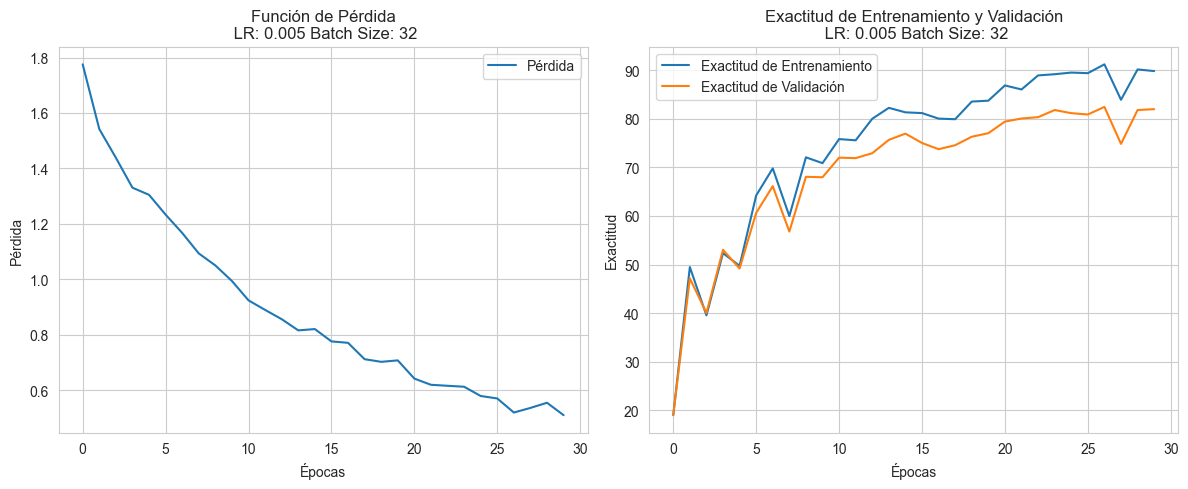


Entrenando con lr=0.005, batch_size=64, epochs=15
    Época 1, pérdida: 1.8010, exactitud entrenamiento: 19.53%, exactitud validación: 20.46%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.5661, exactitud entrenamiento: 39.25%, exactitud validación: 39.91%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.4787, exactitud entrenamiento: 14.76%, exactitud validación: 14.95%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.3861, exactitud entrenamiento: 56.78%, exactitud validación: 55.69%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.3106, exactitud entrenamiento: 48.68%, exactitud validación: 48.17%
Learning rate actual: 0.005000
    Época 6, pérdida: 1.2530, exactitud entrenamiento: 29.11%, exactitud validación: 28.90%
Learning rate actual: 0.005000
    Época 7, pérdida: 1.1868, exactitud entrenamiento: 56.78%, exactitud validación: 54.31%
Learning rate actual: 0.005000
    Época 8, pérdida: 1.1257, exactitud entrenamiento: 57.27%, exactitud validación: 56.

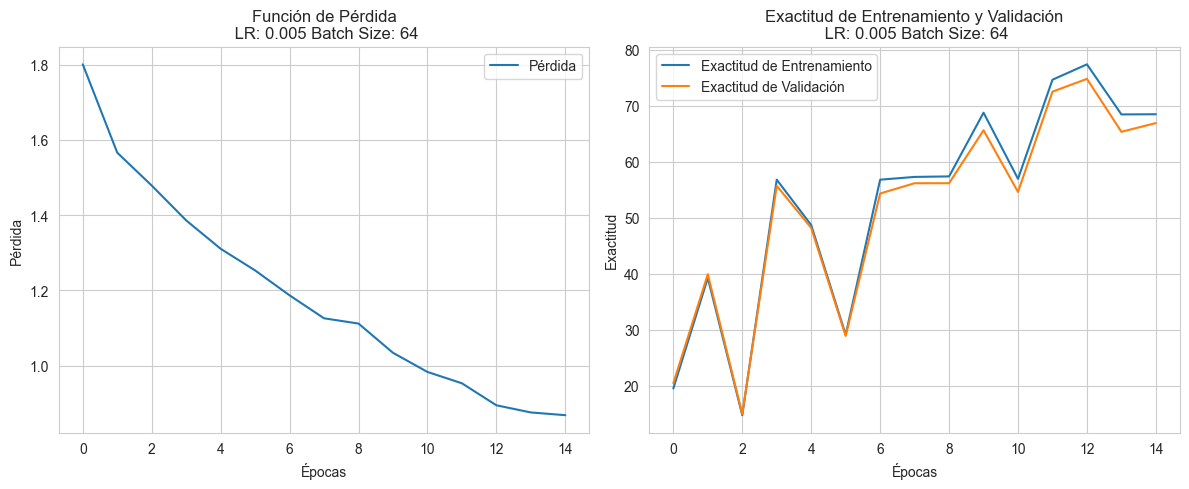


Entrenando con lr=0.005, batch_size=64, epochs=30
    Época 1, pérdida: 1.8013, exactitud entrenamiento: 14.45%, exactitud validación: 14.40%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.5849, exactitud entrenamiento: 21.69%, exactitud validación: 21.93%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.4409, exactitud entrenamiento: 48.83%, exactitud validación: 48.99%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.3814, exactitud entrenamiento: 37.15%, exactitud validación: 37.06%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.2770, exactitud entrenamiento: 34.84%, exactitud validación: 32.66%
Learning rate actual: 0.005000
    Época 6, pérdida: 1.2183, exactitud entrenamiento: 62.20%, exactitud validación: 58.62%
Learning rate actual: 0.005000
    Época 7, pérdida: 1.1851, exactitud entrenamiento: 66.64%, exactitud validación: 63.85%
Learning rate actual: 0.005000
    Época 8, pérdida: 1.1461, exactitud entrenamiento: 64.08%, exactitud validación: 62.

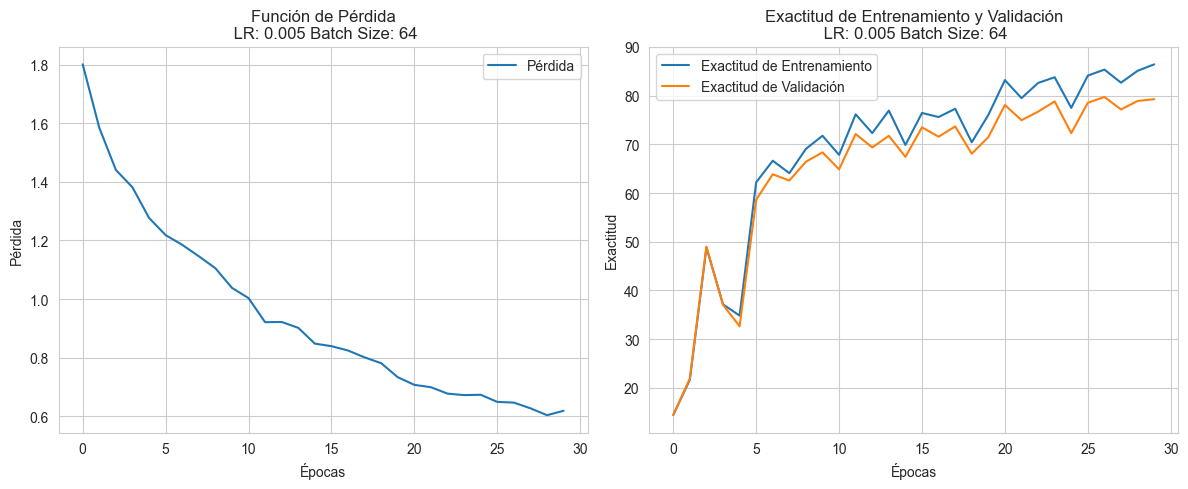


Entrenando con lr=0.001, batch_size=32, epochs=15
    Época 1, pérdida: 1.8567, exactitud entrenamiento: 42.24%, exactitud validación: 42.94%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.6496, exactitud entrenamiento: 46.61%, exactitud validación: 44.77%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.5389, exactitud entrenamiento: 52.65%, exactitud validación: 50.92%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.4591, exactitud entrenamiento: 40.73%, exactitud validación: 42.75%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.3837, exactitud entrenamiento: 60.81%, exactitud validación: 56.88%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.3176, exactitud entrenamiento: 54.00%, exactitud validación: 54.13%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.2763, exactitud entrenamiento: 58.38%, exactitud validación: 56.97%
Learning rate actual: 0.001000
    Época 8, pérdida: 1.2557, exactitud entrenamiento: 47.10%, exactitud validación: 48.

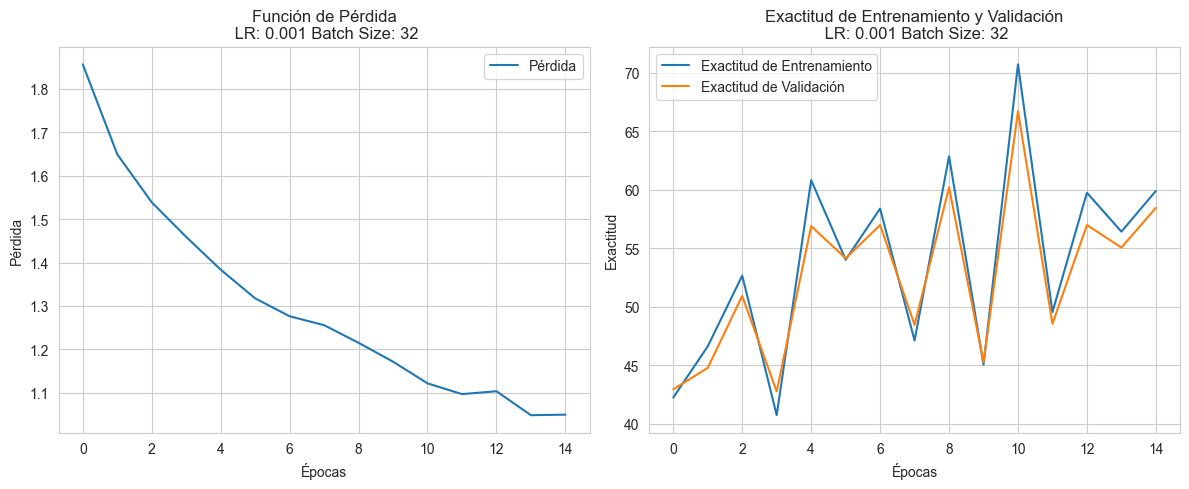


Entrenando con lr=0.001, batch_size=32, epochs=30
    Época 1, pérdida: 1.8338, exactitud entrenamiento: 43.13%, exactitud validación: 43.67%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.6383, exactitud entrenamiento: 35.77%, exactitud validación: 32.66%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.5175, exactitud entrenamiento: 39.09%, exactitud validación: 36.79%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.4212, exactitud entrenamiento: 18.85%, exactitud validación: 18.99%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.3604, exactitud entrenamiento: 63.52%, exactitud validación: 59.91%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.3020, exactitud entrenamiento: 62.78%, exactitud validación: 60.92%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.2824, exactitud entrenamiento: 64.63%, exactitud validación: 61.28%
Learning rate actual: 0.001000
    Época 8, pérdida: 1.2339, exactitud entrenamiento: 66.70%, exactitud validación: 62.

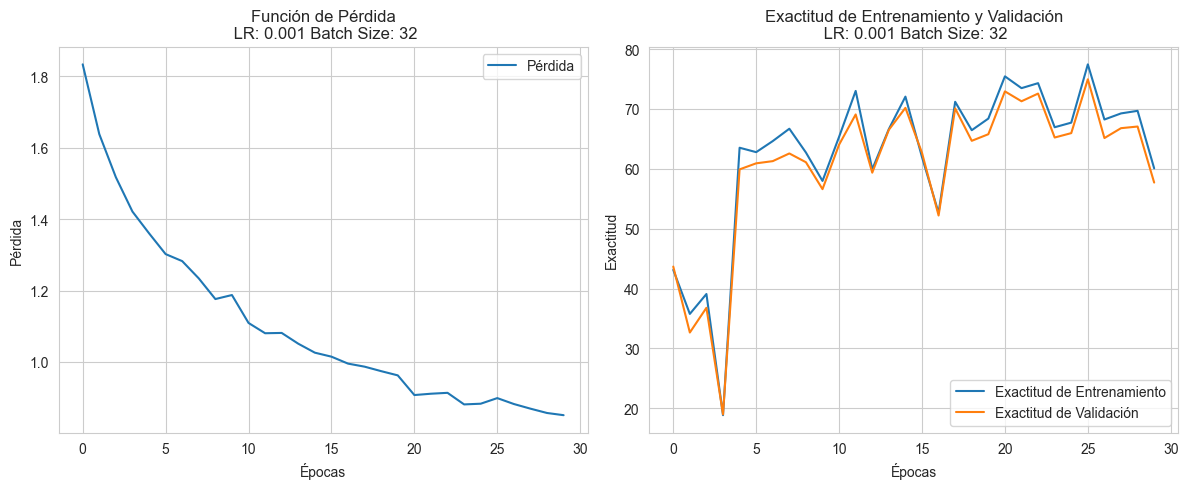


Entrenando con lr=0.001, batch_size=64, epochs=15
    Época 1, pérdida: 1.9001, exactitud entrenamiento: 15.68%, exactitud validación: 15.05%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.7007, exactitud entrenamiento: 39.00%, exactitud validación: 37.43%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.5818, exactitud entrenamiento: 15.50%, exactitud validación: 15.78%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.5092, exactitud entrenamiento: 46.43%, exactitud validación: 48.26%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.4289, exactitud entrenamiento: 43.59%, exactitud validación: 40.55%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.4068, exactitud entrenamiento: 25.69%, exactitud validación: 23.67%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.3281, exactitud entrenamiento: 49.17%, exactitud validación: 49.36%
Learning rate actual: 0.001000
    Época 8, pérdida: 1.2887, exactitud entrenamiento: 29.85%, exactitud validación: 30.

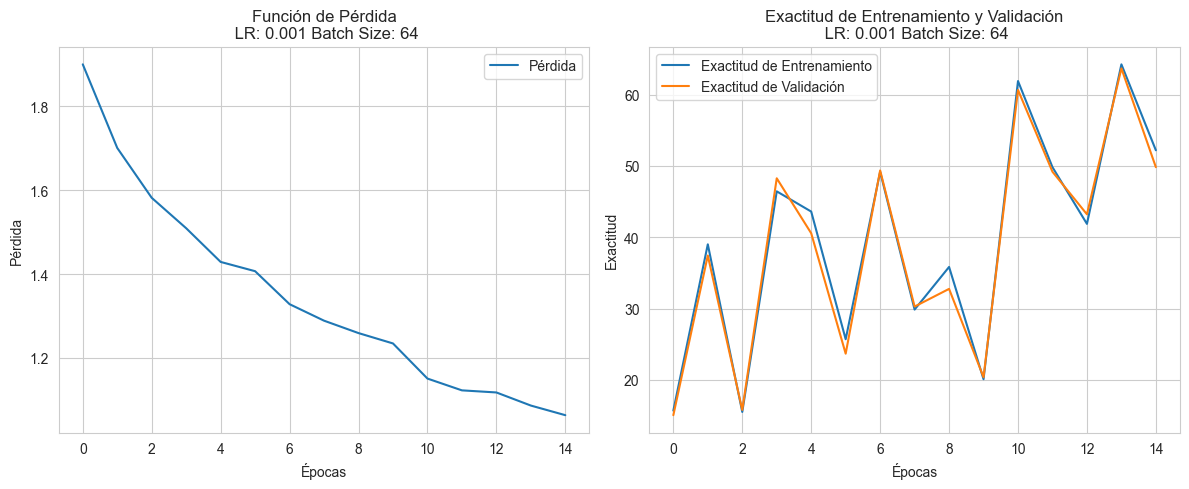


Entrenando con lr=0.001, batch_size=64, epochs=30
    Época 1, pérdida: 1.9183, exactitud entrenamiento: 14.45%, exactitud validación: 14.95%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.7044, exactitud entrenamiento: 33.39%, exactitud validación: 33.67%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.6095, exactitud entrenamiento: 49.26%, exactitud validación: 50.00%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.5214, exactitud entrenamiento: 51.79%, exactitud validación: 47.89%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.4554, exactitud entrenamiento: 58.84%, exactitud validación: 57.43%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.3914, exactitud entrenamiento: 47.47%, exactitud validación: 46.33%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.3596, exactitud entrenamiento: 35.74%, exactitud validación: 34.86%
Learning rate actual: 0.001000
    Época 8, pérdida: 1.2810, exactitud entrenamiento: 58.44%, exactitud validación: 55.

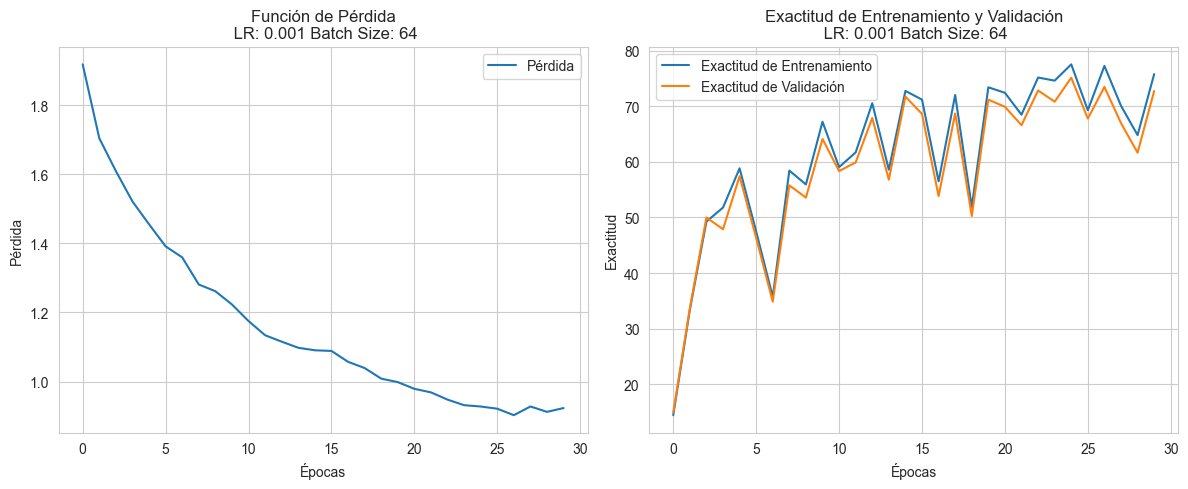


Entrenando con lr=0.0005, batch_size=32, epochs=15
    Época 1, pérdida: 1.8942, exactitud entrenamiento: 32.29%, exactitud validación: 31.38%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.7358, exactitud entrenamiento: 42.02%, exactitud validación: 42.20%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.6386, exactitud entrenamiento: 45.90%, exactitud validación: 44.95%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.5684, exactitud entrenamiento: 33.06%, exactitud validación: 32.48%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.5064, exactitud entrenamiento: 51.45%, exactitud validación: 48.99%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.4558, exactitud entrenamiento: 50.80%, exactitud validación: 50.46%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.4136, exactitud entrenamiento: 36.97%, exactitud validación: 36.70%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.3689, exactitud entrenamiento: 53.85%, exactitud validación: 53

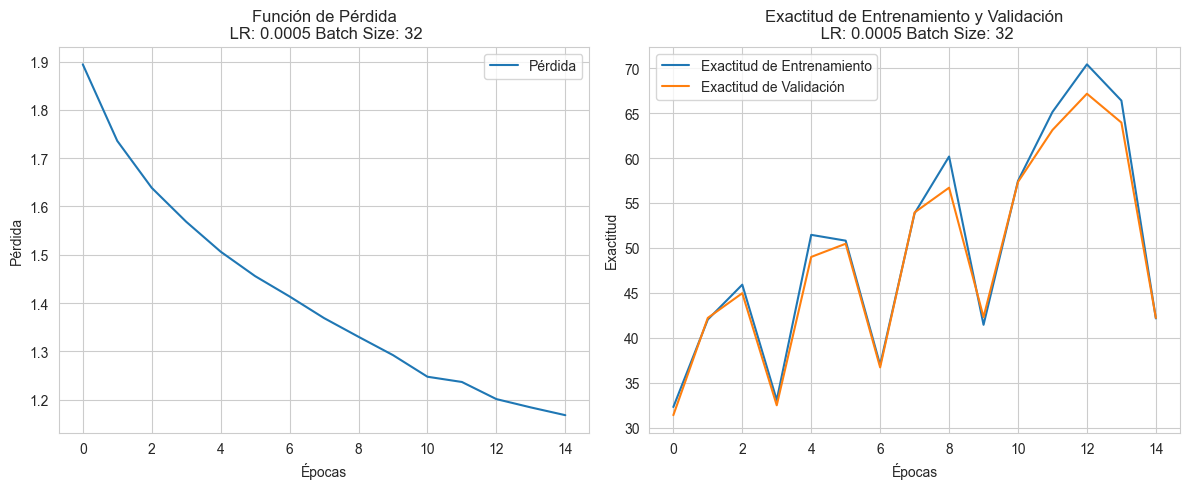


Entrenando con lr=0.0005, batch_size=32, epochs=30
    Época 1, pérdida: 1.8931, exactitud entrenamiento: 37.25%, exactitud validación: 37.25%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.7191, exactitud entrenamiento: 24.12%, exactitud validación: 23.30%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.6418, exactitud entrenamiento: 47.63%, exactitud validación: 44.50%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.5475, exactitud entrenamiento: 34.60%, exactitud validación: 34.86%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.4800, exactitud entrenamiento: 45.69%, exactitud validación: 44.22%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.4444, exactitud entrenamiento: 54.47%, exactitud validación: 54.95%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.4039, exactitud entrenamiento: 62.05%, exactitud validación: 59.82%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.3271, exactitud entrenamiento: 39.46%, exactitud validación: 39

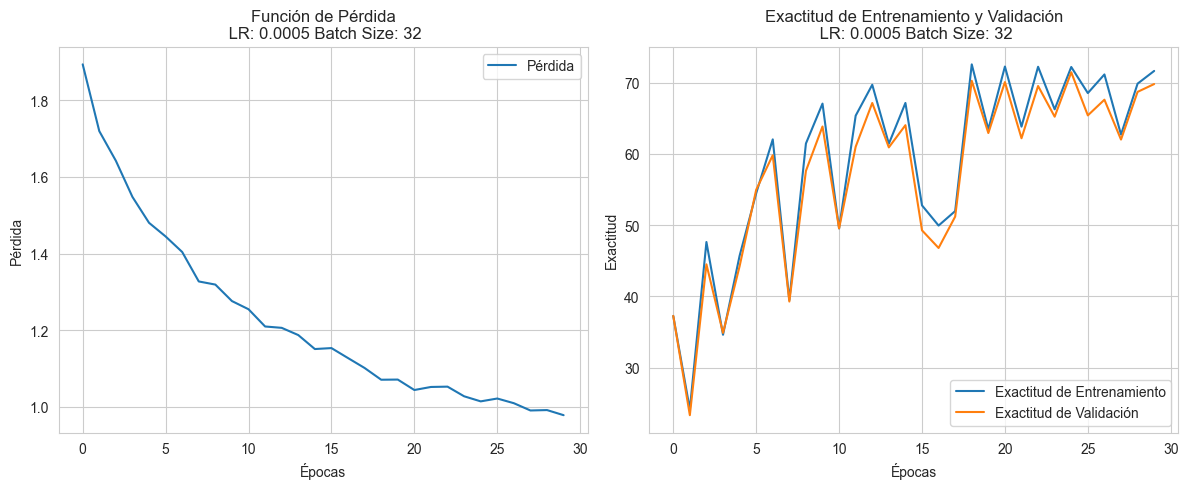


Entrenando con lr=0.0005, batch_size=64, epochs=15
    Época 1, pérdida: 1.9598, exactitud entrenamiento: 19.59%, exactitud validación: 19.54%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.7868, exactitud entrenamiento: 37.83%, exactitud validación: 37.61%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.6915, exactitud entrenamiento: 45.72%, exactitud validación: 45.05%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.6289, exactitud entrenamiento: 14.85%, exactitud validación: 15.05%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.5618, exactitud entrenamiento: 46.49%, exactitud validación: 46.70%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.5255, exactitud entrenamiento: 53.42%, exactitud validación: 51.65%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.4711, exactitud entrenamiento: 46.80%, exactitud validación: 46.70%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.4251, exactitud entrenamiento: 48.83%, exactitud validación: 46

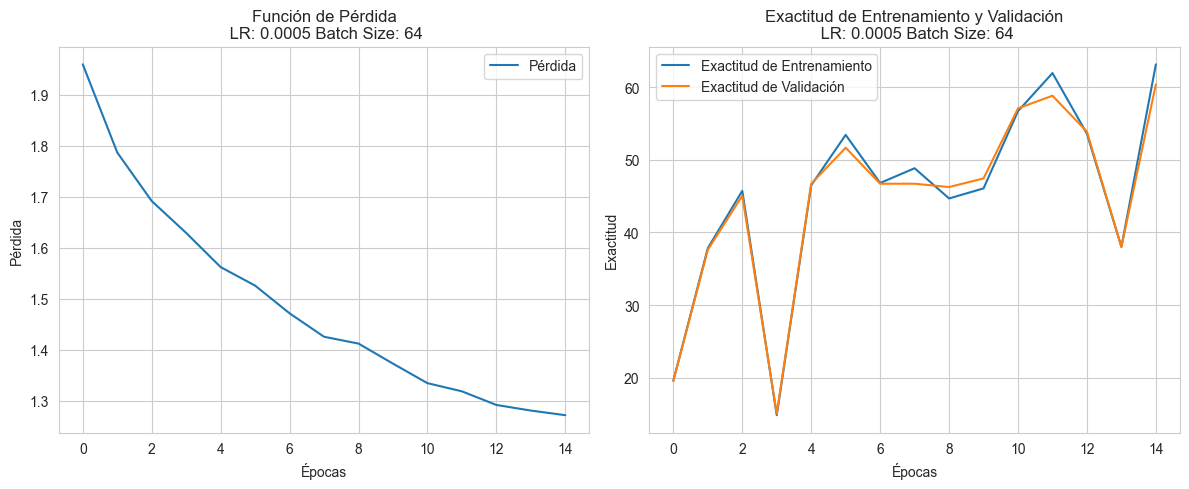


Entrenando con lr=0.0005, batch_size=64, epochs=30
    Época 1, pérdida: 1.9545, exactitud entrenamiento: 28.03%, exactitud validación: 28.53%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.8082, exactitud entrenamiento: 42.27%, exactitud validación: 43.03%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.7058, exactitud entrenamiento: 38.45%, exactitud validación: 38.53%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.6197, exactitud entrenamiento: 32.96%, exactitud validación: 31.56%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.5707, exactitud entrenamiento: 51.57%, exactitud validación: 50.18%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.5172, exactitud entrenamiento: 55.08%, exactitud validación: 51.28%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.4658, exactitud entrenamiento: 47.94%, exactitud validación: 48.26%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.4478, exactitud entrenamiento: 56.72%, exactitud validación: 55

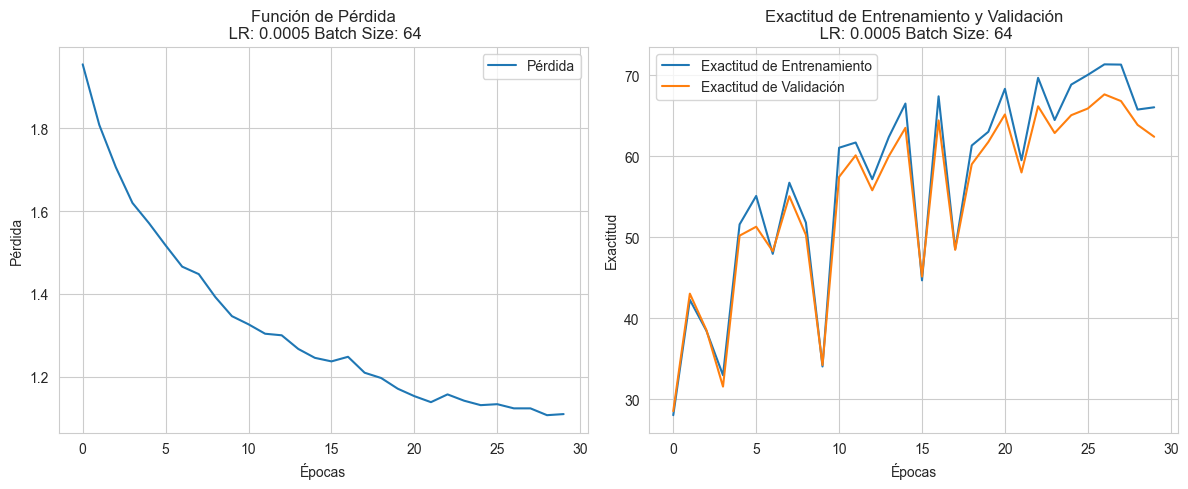


Entrenando con lr=0.0001, batch_size=32, epochs=15
    Época 1, pérdida: 1.9896, exactitud entrenamiento: 32.22%, exactitud validación: 29.82%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9147, exactitud entrenamiento: 27.82%, exactitud validación: 27.16%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.8478, exactitud entrenamiento: 33.61%, exactitud validación: 32.94%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.7952, exactitud entrenamiento: 15.50%, exactitud validación: 15.87%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.7553, exactitud entrenamiento: 36.08%, exactitud validación: 34.59%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.7294, exactitud entrenamiento: 34.53%, exactitud validación: 34.95%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.7061, exactitud entrenamiento: 23.01%, exactitud validación: 23.03%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.6657, exactitud entrenamiento: 42.51%, exactitud validación: 42

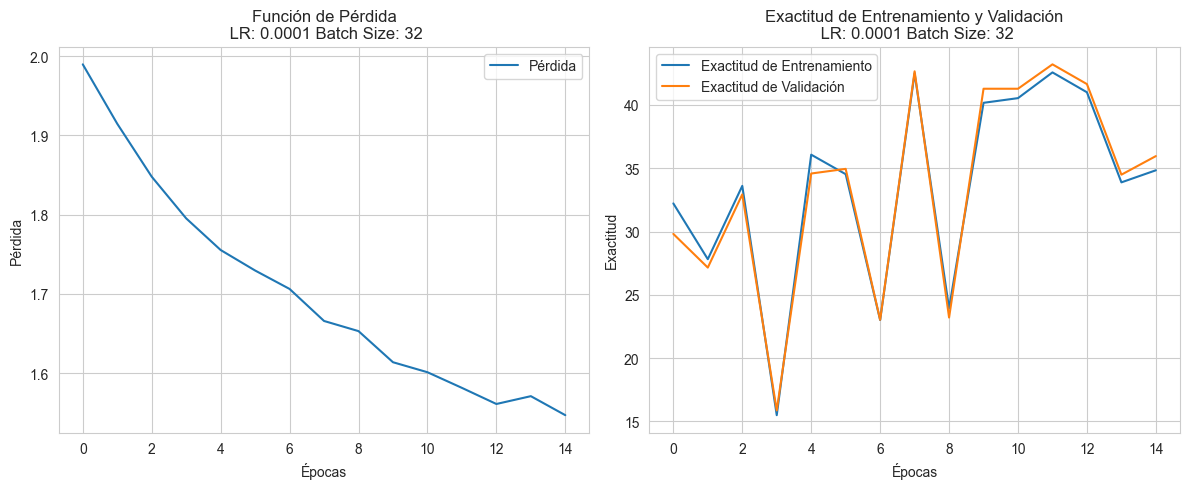


Entrenando con lr=0.0001, batch_size=32, epochs=30
    Época 1, pérdida: 2.0043, exactitud entrenamiento: 18.21%, exactitud validación: 18.44%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9294, exactitud entrenamiento: 33.30%, exactitud validación: 32.84%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.8667, exactitud entrenamiento: 33.12%, exactitud validación: 33.39%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.8114, exactitud entrenamiento: 41.28%, exactitud validación: 41.74%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.7854, exactitud entrenamiento: 37.77%, exactitud validación: 36.42%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.7378, exactitud entrenamiento: 28.19%, exactitud validación: 28.26%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.7058, exactitud entrenamiento: 32.50%, exactitud validación: 32.48%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.6858, exactitud entrenamiento: 27.30%, exactitud validación: 27

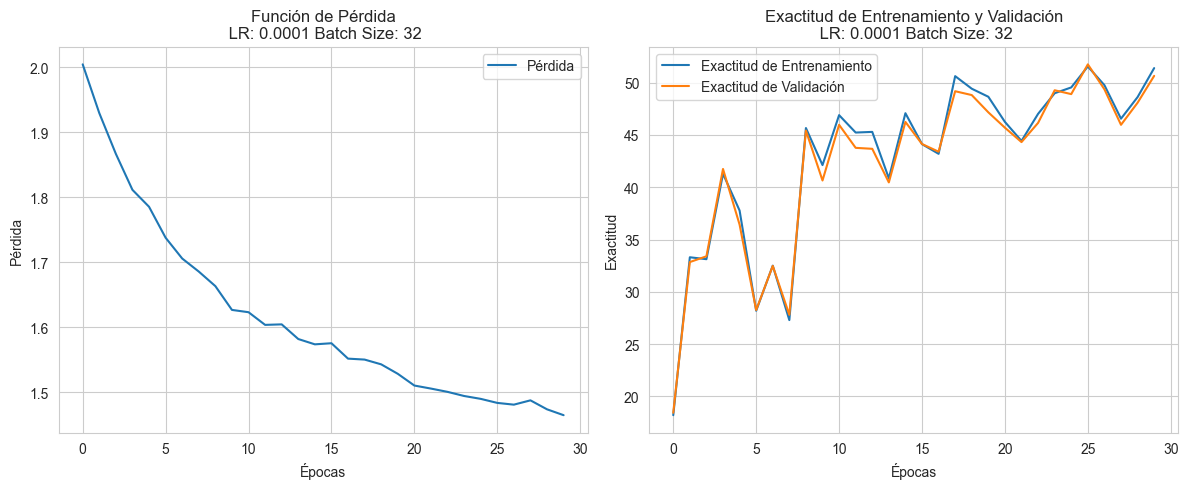


Entrenando con lr=0.0001, batch_size=64, epochs=15
    Época 1, pérdida: 1.9913, exactitud entrenamiento: 14.60%, exactitud validación: 14.40%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9855, exactitud entrenamiento: 31.76%, exactitud validación: 31.28%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.9272, exactitud entrenamiento: 31.89%, exactitud validación: 32.66%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.8881, exactitud entrenamiento: 35.43%, exactitud validación: 35.32%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.8399, exactitud entrenamiento: 18.42%, exactitud validación: 19.63%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.8227, exactitud entrenamiento: 41.44%, exactitud validación: 41.19%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.7942, exactitud entrenamiento: 24.83%, exactitud validación: 24.50%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.7577, exactitud entrenamiento: 17.99%, exactitud validación: 19

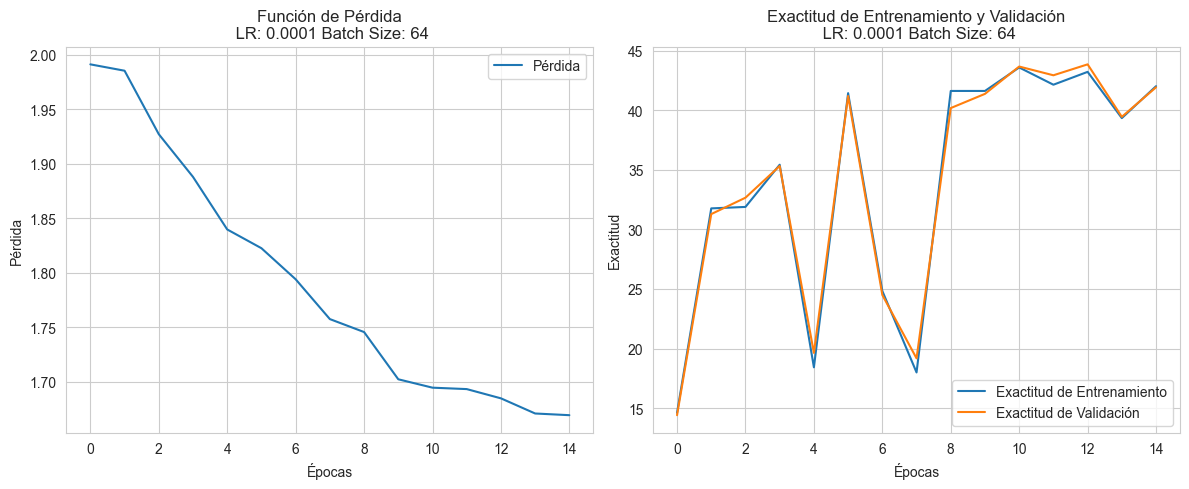


Entrenando con lr=0.0001, batch_size=64, epochs=30
    Época 1, pérdida: 2.0149, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9771, exactitud entrenamiento: 27.57%, exactitud validación: 27.61%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.9078, exactitud entrenamiento: 32.10%, exactitud validación: 31.56%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.8525, exactitud entrenamiento: 28.37%, exactitud validación: 28.17%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.8135, exactitud entrenamiento: 37.25%, exactitud validación: 38.17%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.7905, exactitud entrenamiento: 37.31%, exactitud validación: 38.44%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.7447, exactitud entrenamiento: 36.85%, exactitud validación: 36.61%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.7270, exactitud entrenamiento: 40.20%, exactitud validación: 42

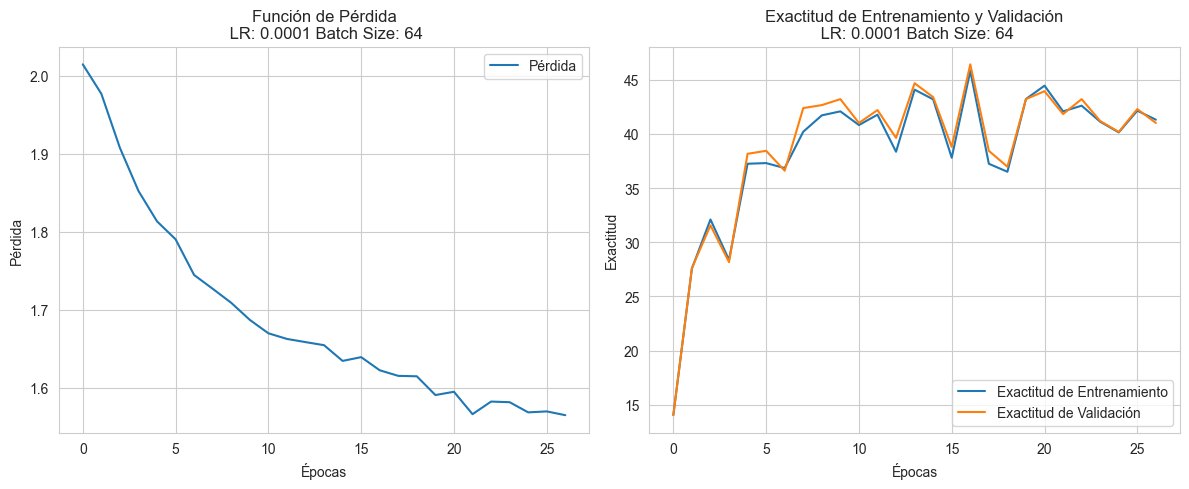


Entrenando con lr=5e-05, batch_size=32, epochs=15
    Época 1, pérdida: 2.0052, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.9957, exactitud entrenamiento: 14.63%, exactitud validación: 14.13%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.9777, exactitud entrenamiento: 25.29%, exactitud validación: 25.41%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9310, exactitud entrenamiento: 26.74%, exactitud validación: 25.23%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.8942, exactitud entrenamiento: 30.71%, exactitud validación: 29.54%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.8602, exactitud entrenamiento: 32.26%, exactitud validación: 31.93%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.8352, exactitud entrenamiento: 36.66%, exactitud validación: 35.69%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.8067, exactitud entrenamiento: 35.98%, exactitud validación: 35.

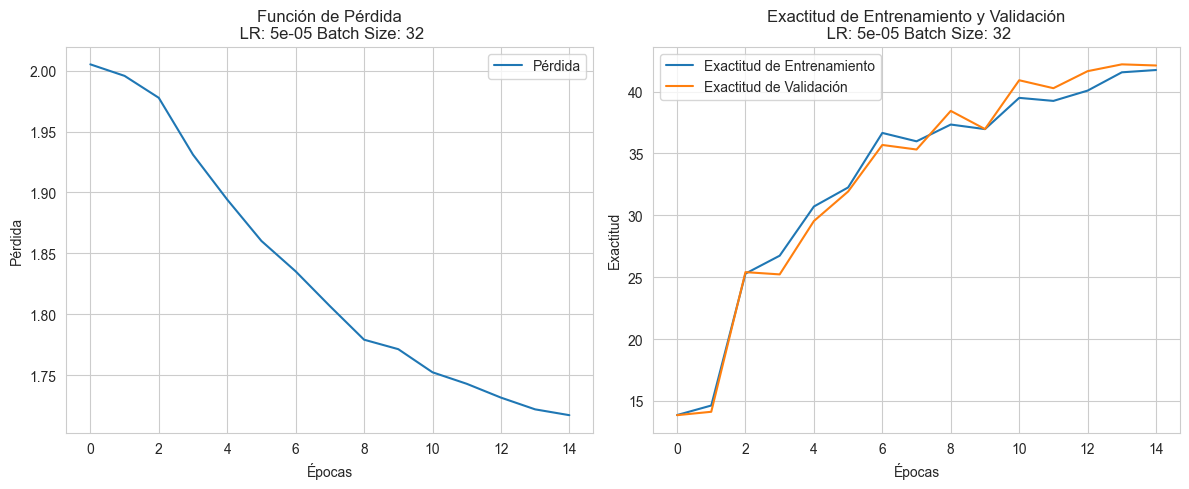


Entrenando con lr=5e-05, batch_size=32, epochs=30
    Época 1, pérdida: 1.9968, exactitud entrenamiento: 17.07%, exactitud validación: 16.51%
Learning rate actual: 0.000050
    Época 2, pérdida: 1.9849, exactitud entrenamiento: 21.69%, exactitud validación: 20.46%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.9619, exactitud entrenamiento: 27.54%, exactitud validación: 28.44%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9239, exactitud entrenamiento: 32.81%, exactitud validación: 33.85%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.8907, exactitud entrenamiento: 34.32%, exactitud validación: 34.22%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.8682, exactitud entrenamiento: 34.29%, exactitud validación: 34.31%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.8417, exactitud entrenamiento: 36.48%, exactitud validación: 36.42%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.8146, exactitud entrenamiento: 37.55%, exactitud validación: 36.

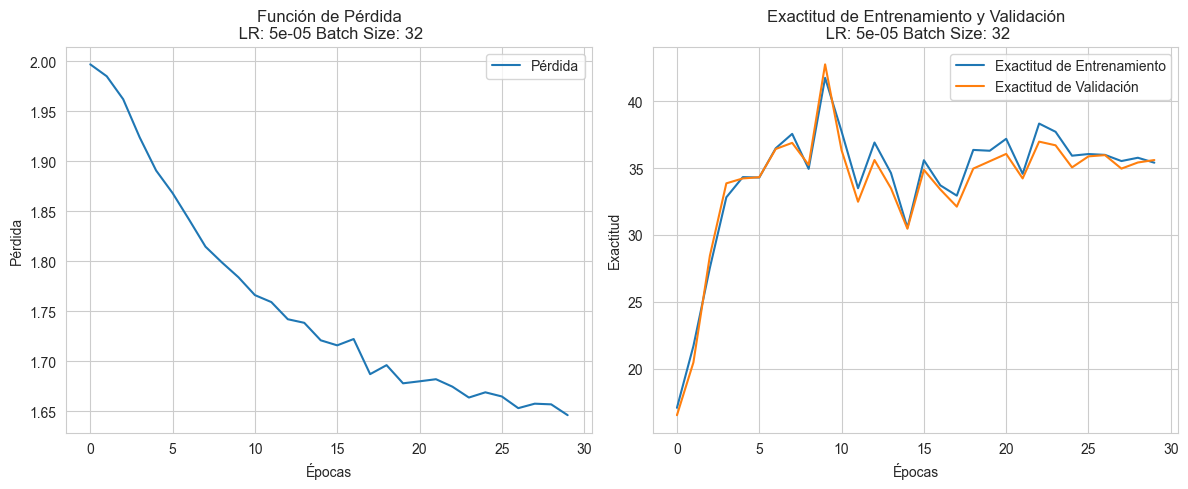


Entrenando con lr=5e-05, batch_size=64, epochs=15
    Época 1, pérdida: 2.0328, exactitud entrenamiento: 14.17%, exactitud validación: 13.85%
Learning rate actual: 0.000050
    Época 2, pérdida: 2.0137, exactitud entrenamiento: 14.20%, exactitud validación: 13.85%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.9961, exactitud entrenamiento: 29.42%, exactitud validación: 27.80%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9692, exactitud entrenamiento: 30.84%, exactitud validación: 30.00%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.9242, exactitud entrenamiento: 32.07%, exactitud validación: 30.00%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.8998, exactitud entrenamiento: 34.47%, exactitud validación: 33.21%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.8683, exactitud entrenamiento: 34.84%, exactitud validación: 34.68%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.8449, exactitud entrenamiento: 35.86%, exactitud validación: 36.

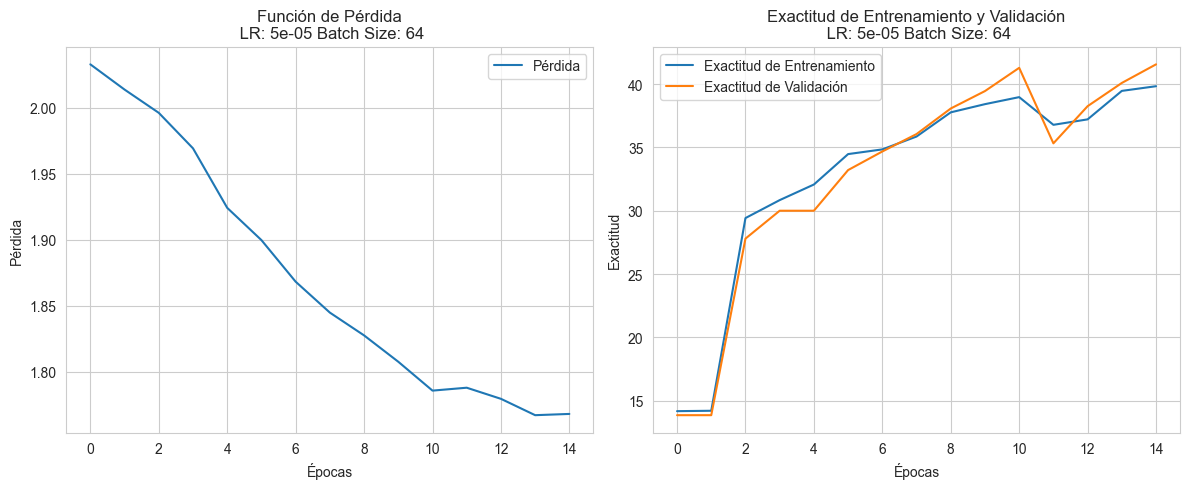


Entrenando con lr=5e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0036, exactitud entrenamiento: 15.80%, exactitud validación: 16.24%
Learning rate actual: 0.000050
    Época 2, pérdida: 2.0008, exactitud entrenamiento: 15.80%, exactitud validación: 16.24%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.9899, exactitud entrenamiento: 18.18%, exactitud validación: 18.44%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9384, exactitud entrenamiento: 28.90%, exactitud validación: 30.46%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.9096, exactitud entrenamiento: 29.08%, exactitud validación: 29.36%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.8699, exactitud entrenamiento: 29.79%, exactitud validación: 30.83%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.8607, exactitud entrenamiento: 31.21%, exactitud validación: 32.11%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.8460, exactitud entrenamiento: 31.45%, exactitud validación: 31.

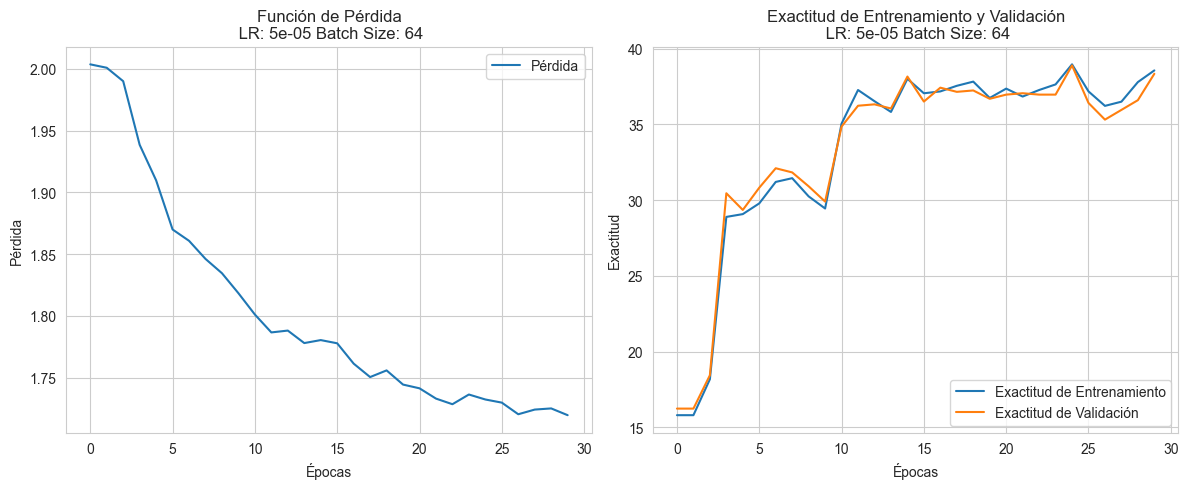


Entrenando con lr=1e-05, batch_size=32, epochs=15
    Época 1, pérdida: 2.0126, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0177, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0087, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0097, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.9905, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.9947, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.9935, exactitud entrenamiento: 13.86%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.9884, exactitud entrenamiento: 14.51%, exactitud validación: 14.

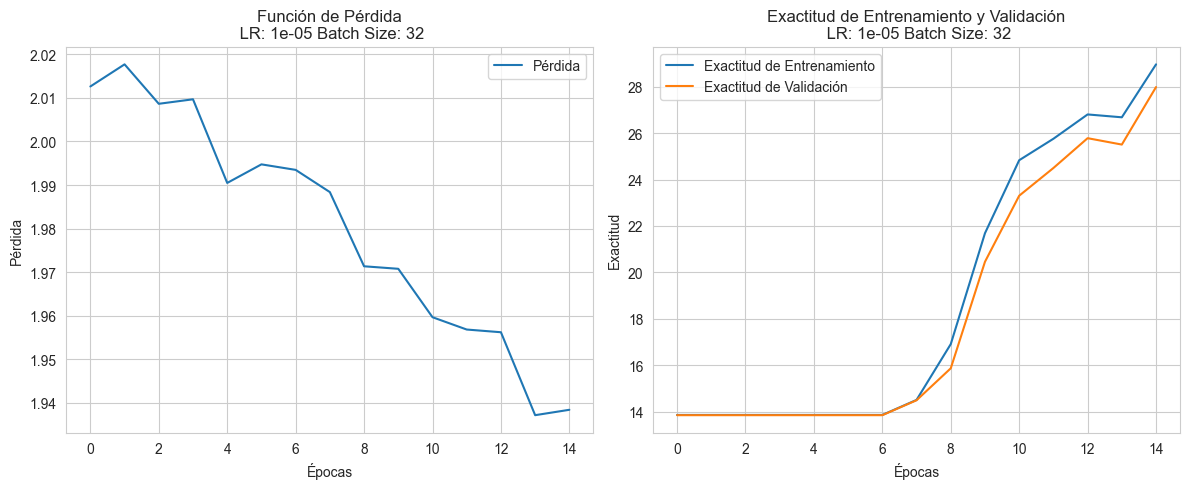


Entrenando con lr=1e-05, batch_size=32, epochs=30
    Época 1, pérdida: 2.0268, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0145, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0196, exactitud entrenamiento: 14.45%, exactitud validación: 14.68%
Learning rate actual: 0.000010
    Época 4, pérdida: 1.9988, exactitud entrenamiento: 16.05%, exactitud validación: 15.60%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.9997, exactitud entrenamiento: 14.94%, exactitud validación: 14.50%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.9984, exactitud entrenamiento: 15.10%, exactitud validación: 14.31%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.9858, exactitud entrenamiento: 15.25%, exactitud validación: 14.22%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.9843, exactitud entrenamiento: 16.85%, exactitud validación: 15.

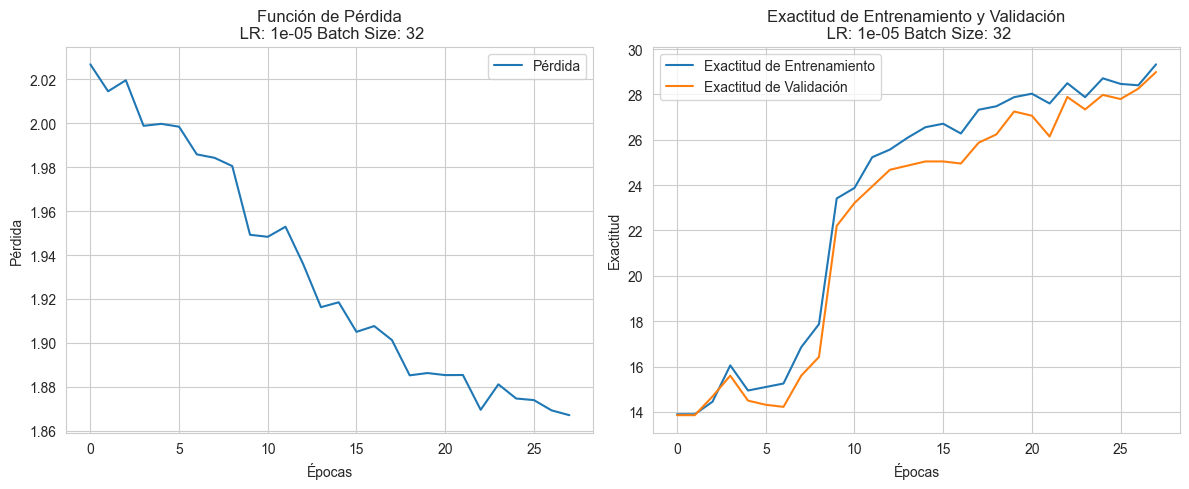


Entrenando con lr=1e-05, batch_size=64, epochs=15
    Época 1, pérdida: 2.0052, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0012, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0090, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0053, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0164, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
Parada anticipada activada


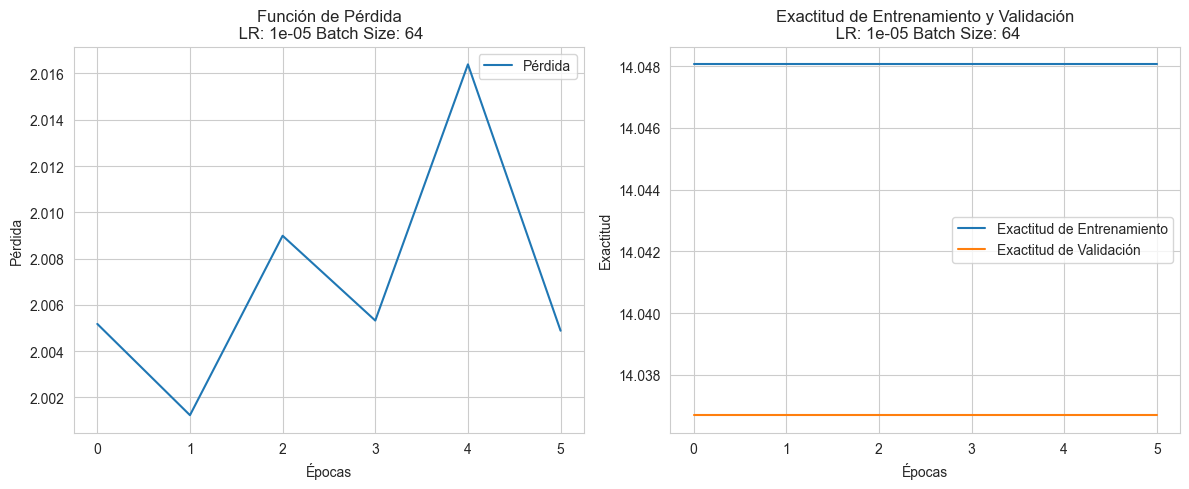


Entrenando con lr=1e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0205, exactitud entrenamiento: 15.80%, exactitud validación: 16.24%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0159, exactitud entrenamiento: 15.80%, exactitud validación: 16.24%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0067, exactitud entrenamiento: 15.80%, exactitud validación: 16.24%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0029, exactitud entrenamiento: 15.80%, exactitud validación: 16.24%
Learning rate actual: 0.000010
    Época 5, pérdida: 1.9965, exactitud entrenamiento: 15.80%, exactitud validación: 16.24%
Learning rate actual: 0.000010
    Época 6, pérdida: 1.9880, exactitud entrenamiento: 15.80%, exactitud validación: 16.24%
Learning rate actual: 0.000010
    Época 7, pérdida: 1.9992, exactitud entrenamiento: 15.80%, exactitud validación: 16.24%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.9973, exactitud entrenamiento: 15.80%, exactitud validación: 16.

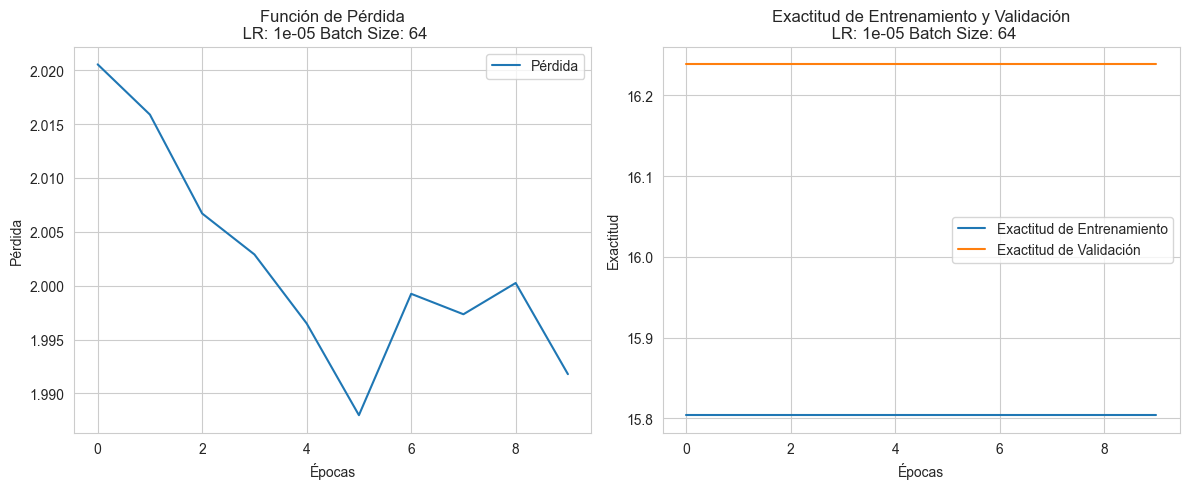

In [7]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from itertools import product

learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
batch_sizes = [32, 64]
epochs_list = [15, 30]

resultados = []
modelos = {}

for lr, batch_size, epochs in product(learning_rates, batch_sizes, epochs_list):

    # Crear DataLoaders para los datos de entrenamiento, validación y test
    dataloader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=batch_size, shuffle=True)
    dataloader_validacion = DataLoader(dataset_validacion, batch_size=batch_size, shuffle=False)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    modelo = ConvNet().to(device)
    criterio = nn.CrossEntropyLoss()
    optimizador = optim.Adam(modelo.parameters(), lr=lr)
    scheduler = StepLR(optimizador, step_size=10, gamma=0.5)

    combinacion = (lr, batch_size, epochs)
    print(f"\nEntrenando con lr={lr}, batch_size={batch_size}, epochs={epochs}")

    modelos[combinacion] = modelo

    valores_perdida = []
    exactitud_entrenamiento = []
    exactitud_validacion = []

    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoca in range(epochs):
        modelos[combinacion].train()
        running_loss = 0.0
        for images, labels in dataloader_entrenamiento:
            images, labels = images.to(device), labels.to(device)
            outputs = modelos[combinacion](images)
            loss = criterio(outputs, labels)
            loss.backward()
            optimizador.step()
            optimizador.zero_grad()
            running_loss += loss.item()

        valores_perdida.append(running_loss / len(dataloader_entrenamiento))

        with torch.no_grad():
            modelos[combinacion].eval()

            # Calcular exactitud de entrenamiento
            correctas = 0
            total = 0
            for images, labels in dataloader_entrenamiento:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_entrenamiento.append(100 * correctas / total)

            # Calcular exactitud de validación
            correctas = 0
            total = 0
            for images, labels in dataloader_validacion:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_validacion.append(100 * correctas / total)
        
        scheduler.step()
        
        # Early stopping
        val_loss = valores_perdida[-1]  # Usamos la pérdida más reciente
        early_stopping(val_loss, modelo)

        # Verifica si se activa la parada anticipada
        if early_stopping.early_stop:
            print("Parada anticipada activada")
            modelo.load_state_dict(early_stopping.best_model_wts)  # Cargar los mejores pesos
            break

        # Imprimir métricas de la época
        print(f'    Época {epoca+1}, pérdida: {val_loss:.4f}, exactitud entrenamiento: {exactitud_entrenamiento[-1]:.2f}%, exactitud validación: {exactitud_validacion[-1]:.2f}%')
        
        for param_group in optimizador.param_groups:
            print(f"Learning rate actual: {param_group['lr']:.6f}")

    graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion)
    resultados.append((lr, batch_size, epochs, exactitud_validacion[-1]))


Top configuraciones:
    LR=0.005, Batch=32, Epochs=30, Exactitud validación=82.02%
    LR=0.005, Batch=64, Epochs=30, Exactitud validación=79.27%
    LR=0.005, Batch=32, Epochs=15, Exactitud validación=74.50%
    LR=0.001, Batch=64, Epochs=30, Exactitud validación=72.75%
    LR=0.0005, Batch=32, Epochs=30, Exactitud validación=69.82%

Exactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR=0.005, Batch=32, Epochs=30    : 78.66%
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8440    0.6174    0.7132       149
           1     0.8045    0.9474    0.8701       152
           2     0.8125    0.6980    0.7509       149
           3     0.8063    0.7457    0.7748       173
           4     0.6990    0.9133    0.7919       150
           5     0.8235    0.6577    0.7313       149
           6     0.7701    0.9231    0.8397       156

    accuracy                         0.7866      1078
   macro avg     0.7943    

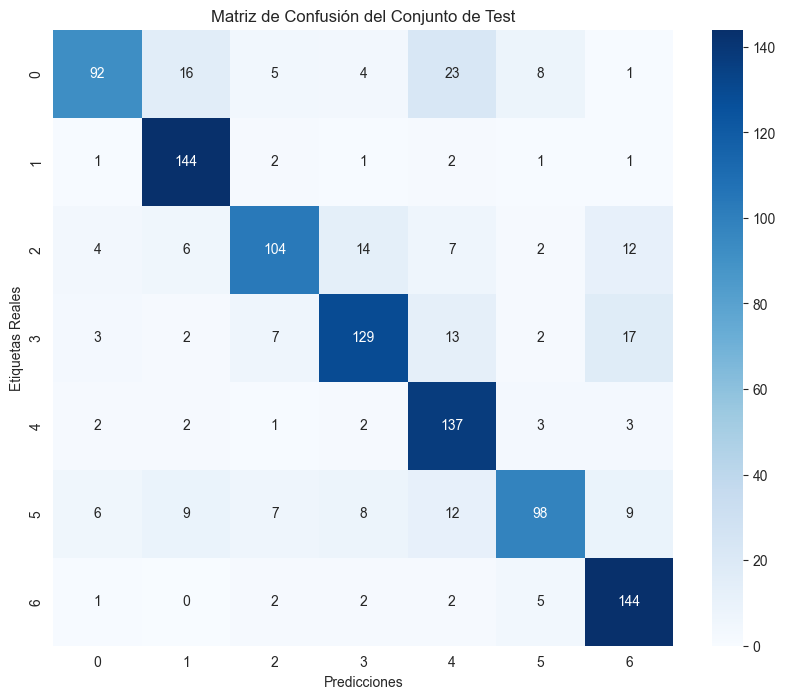

Clases presentes en el conjunto de test: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}


In [9]:
mejores_resultados = sorted(resultados, key=lambda x: x[3], reverse=True)
print("Top configuraciones:")
for res in mejores_resultados[:5]:
    print(f"    LR={res[0]}, Batch={res[1]}, Epochs={res[2]}, Exactitud validación={res[3]:.2f}%")

mejor = (mejores_resultados[0][0], mejores_resultados[0][1], mejores_resultados[0][2])
modelo = modelos[mejor]
exactitud_test = calcular_exactitud_test(modelo, dataloader_test, device)
print(f"\nExactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR={mejor[0]}, Batch={mejor[1]}, Epochs={mejor[2]}    : {exactitud_test:.2f}%")
matriz_de_confusion(modelo, dataloader_test, device)